# Purpose of analysis

The questions for the analysis:
- Which cities have the highest number of data job listings?
- What sectors are hiring for data roles?
- Do larger companies offer higher salary estimates for data analytics/science positions compared to smaller companies?
- Are there significant salary variations based on the location and sector?
- Predict the base salary
- Segment the estimated base salary into groups to identify patterns

Dataset overview:
- Australia's data science job listings scrapped from Glassdoor
- The date of the data is up to Dec, 2022, however, the date for each data point is unclear
- Link to the dataset: https://www.kaggle.com/datasets/nadzmiagthomas/australia-data-science-jobs/data

# Data Exploration
## Overview

In [597]:
# Import libraries for data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)

In [598]:
# Merge the old and new datasets for more data
data_old = pd.read_csv('AustraliaDataScienceJobs.csv')
data_new = pd.read_csv('AustraliaDataScienceJob2.csv')
df = pd.concat([data_old, data_new], ignore_index=True)
df.head()

,Job Title,Job Location,Company,Url,Estimate Base Salary,Low Estimate,High Estimate,Company Size,Company Type,Company Sector,...,cassandra_yn,hive_yn,bigml_yn,tableau_yn,powerbi_yn,nlp_yn,pytorch_yn,tensorflow_yn,mathematic_yn,statistic_yn
0,Analyst,Melbourne,ANZ Banking Group,https://www.glassdoor.com.au/partner/jobListin...,95917,80000,115000,10000+ Employees,Company - Public,Finance,...,0,0,0,0,0,0,0,0,1,0
1,Clinical Research Associate,Mulgrave,Bristol Myers Squibb,https://www.glassdoor.com.au/partner/jobListin...,96555,79000,118000,10000+ Employees,Company - Public,Pharmaceutical & Biotechnology,...,0,0,0,0,0,0,0,0,0,0
2,Clinical Research Associate,Mulgrave,Bristol Myers Squibb,https://www.glassdoor.com.au/partner/jobListin...,96555,79000,118000,10000+ Employees,Company - Public,Pharmaceutical & Biotechnology,...,0,0,0,0,0,0,0,0,0,0
3,Clinical Research Associate,Mulgrave,Bristol Myers Squibb,https://www.glassdoor.com.au/partner/jobListin...,96555,79000,118000,10000+ Employees,Company - Public,Pharmaceutical & Biotechnology,...,0,0,0,0,0,0,0,0,0,0
4,Data Scientist,Melbourne,ANZ Banking Group,https://www.glassdoor.com.au/partner/jobListin...,115631,94000,143000,10000+ Employees,Company - Public,Finance,...,0,0,0,0,0,0,0,0,0,0


In [599]:
df.shape

(2740, 53)

In [600]:
df.columns

Index(['Job Title', 'Job Location', 'Company', 'Url', 'Estimate Base Salary',
       'Low Estimate', 'High Estimate', 'Company Size', 'Company Type',
       'Company Sector', 'Company Founded', 'Company Industry',
       'Company Revenue', 'Job Descriptions', 'Company Rating',
       'Company Friend Reccomendation', 'Company CEO Approval',
       'Companny Number of Rater', 'Company Career Opportinities',
       'Compensation and Benefits', 'Company Culture and Values',
       'Company Senior Management', 'Company Work Life Balance', 'Country',
       'State', 'python_yn', 'r_yn', 'sql_yn', 'java_yn', 'julia_yn',
       'scala_yn', 'c_yn', 'c++_yn', 'javascript_yn', 'spark_yn', 'hadoop_yn',
       'matlab_yn', 'sas_yn', 'git_yn', 'excel_yn', 'nosql_yn', 'aws_yn',
       'mongodb_yn', 'cassandra_yn', 'hive_yn', 'bigml_yn', 'tableau_yn',
       'powerbi_yn', 'nlp_yn', 'pytorch_yn', 'tensorflow_yn', 'mathematic_yn',
       'statistic_yn'],
      dtype='object')

In [601]:
# Select only the interested columns and ones we can easily obtain when doing a job search
df = df[['Job Title', 'Job Location', 'Company', 'Estimate Base Salary', 'Company Size', 'Company Type', 'Company Sector', 'Company Rating', 'Company Work Life Balance']]

In [602]:
df.describe()

,Estimate Base Salary,Company Rating,Company Work Life Balance
count,2740.000000,2314.000000,2270.000000
mean,103185.945255,3.884313,3.772291
std,32620.513310,0.517118,0.589988
min,40500.000000,1.600000,1.000000
25%,80623.000000,3.700000,3.400000
50%,96130.000000,3.900000,3.800000
75%,120181.000000,4.100000,4.100000
max,295000.000000,5.000000,5.000000


In [603]:
# Get the top 5 data job titles
df["Job Title"].value_counts()[:5]

Data Scientist               449
Data Analyst                 215
Data Engineer                120
Software Engineer             89
Machine Learning Engineer     78
Name: Job Title, dtype: int64

In [604]:
# We're only interested in data-related roles so we'll drop the rest (e.g. data engineer, data analyst, machine learning engineer, etc.)
df = df[df["Job Title"].isin(["Data Scientist", "Data Analyst", "Data Engineer", "Machine Learning Engineer"])]
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Estimate Base Salary,862.0,110900.559165,29083.137287,50400.0,90205.0,110715.0,125000.0,200000.0
Company Rating,717.0,3.865830,0.489146,2.0,3.6,3.9,4.1,5.0
Company Work Life Balance,717.0,3.732357,0.579165,1.0,3.2,3.7,4.0,5.0


In [605]:
# Drop the bottom 1% and top 1% of the data to exclude extreme outliers
df = df[df["Estimate Base Salary"] > df["Estimate Base Salary"].quantile(0.01)]

## Handle missing values

In [606]:
# Create a new DataFrame to store missing percentages
missing_percentages_df = pd.DataFrame(columns=["Column Name", "Missing Percentage (%)"])

# Calculate and append missing percentages for each column
for column in df.columns:
    missing_percentage = (df[column].isnull().sum() / len(df)) * 100
    missing_percentages_df = missing_percentages_df.append({"Column Name": column, "Missing Percentage (%)": missing_percentage}, ignore_index=True)
print(missing_percentages_df)

                 Column Name Missing Percentage (%)
0                  Job Title                    0.0
1               Job Location                    0.0
2                    Company                    0.0
3       Estimate Base Salary                    0.0
4               Company Size                7.02381
5               Company Type                7.02381
6             Company Sector               29.52381
7             Company Rating              17.261905
8  Company Work Life Balance              17.261905


- We will drop rows in columns with less than 20% (a common threshold) of data missing but before we do that, we need to make sure it's appropriate whether it's to drop the rows in Company Sector as well because it has 27% of data missing, and dropping them might affect the analysis.
- To see if the missing data is significantly different from the non-missing data, we need to compare the Estimate Base Salary of the rows with missing Company Sector to the rows with non-missing Company Sector 

Text(0.5, 1.0, "Non-missing 'Company Sector'")

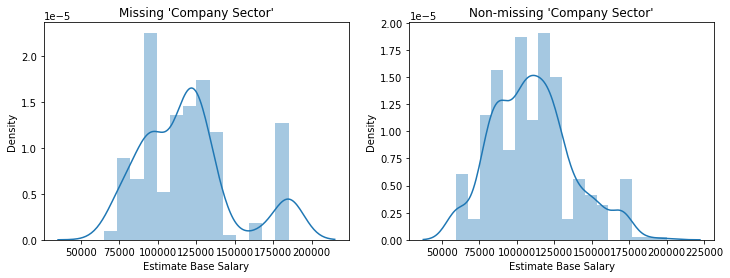

In [579]:
# Plot the distribution of Estimate Base Salary for rows with missing Company Sector
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.distplot(df[df["Company Sector"].isnull()]["Estimate Base Salary"])
plt.title("Missing 'Company Sector'")
plt.subplot(1, 2, 2)
sns.distplot(df[df["Company Sector"].notnull()]["Estimate Base Salary"])
plt.title("Non-missing 'Company Sector'")

From the graphs, we can see that the distribution for the missing data and non-missing data are similar, therefore, it's appropriate to drop the NA rows in Company Sector.

In [580]:
# Drop all the rows with missing data
df = df.dropna()

## Exploratory data analysis

### Question: Which cities have the highest number of data job listings?

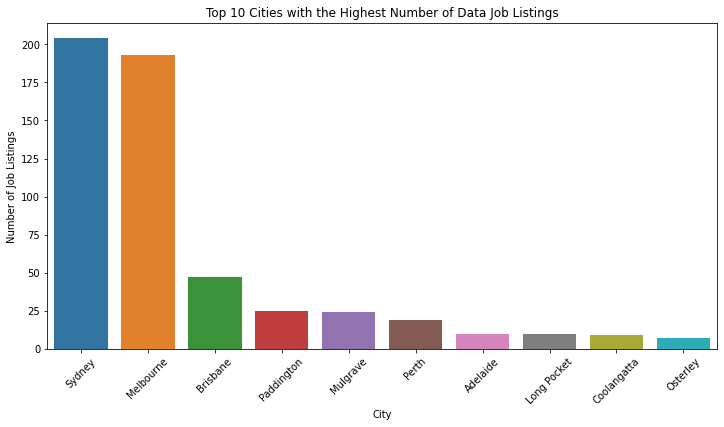

In [581]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Job Location', order=df['Job Location'].value_counts().index[:10])
plt.xticks(rotation=45)
plt.title('Top 10 Cities with the Highest Number of Data Job Listings')
plt.xlabel('City')
plt.ylabel('Number of Job Listings')
plt.show()

- Sydney and Melbourne have the most job listings and the numbers are substantially more than all other cities combined
- The capital city, which is Canberra, doesn't have many job listings since it wasn't in the top 10

### Question: What sectors are hiring for data roles?

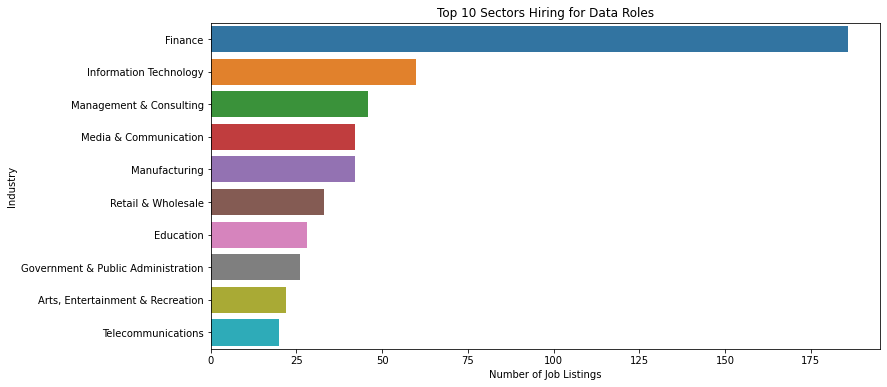

In [582]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='Company Sector', order=df['Company Sector'].value_counts().index[:10])
plt.title('Top 10 Sectors Hiring for Data Roles')
plt.xlabel('Number of Job Listings')
plt.ylabel('Industry')
plt.show()

- The finance sector demands the most data roles, it's tripled the number of roles offered by the second-highest sector
- The reason might be the increasing complexity of the financial markets and the volume of data and businesses need to make sense of it 

### Question: Do larger companies offer higher salary estimates for data analytics/science positions compared to smaller companies?

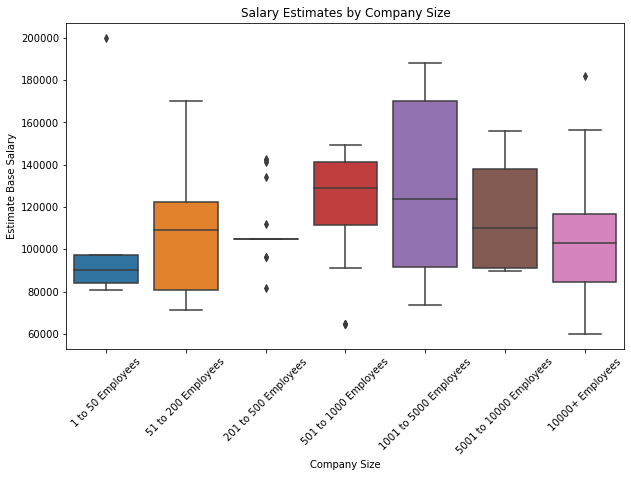

In [583]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Company Size', y='Estimate Base Salary', order=['1 to 50 Employees', '51 to 200 Employees', '201 to 500 Employees', '501 to 1000 Employees', '1001 to 5000 Employees', '5001 to 10000 Employees', '10000+ Employees'])
plt.title('Salary Estimates by Company Size')
plt.xlabel('Company Size')
plt.ylabel('Estimate Base Salary')
plt.xticks(rotation=45)
plt.show()


- Small companies with less than 50 employees offer salaries that are less than 100 thousand AUD a year
- Companies with 1000 to 5000 employees generally offer more than 100 to 180 thousand AUD a year
- The difference in salary is not significant in other companies sizes

### Question: Are there significant salary variations based on the location?

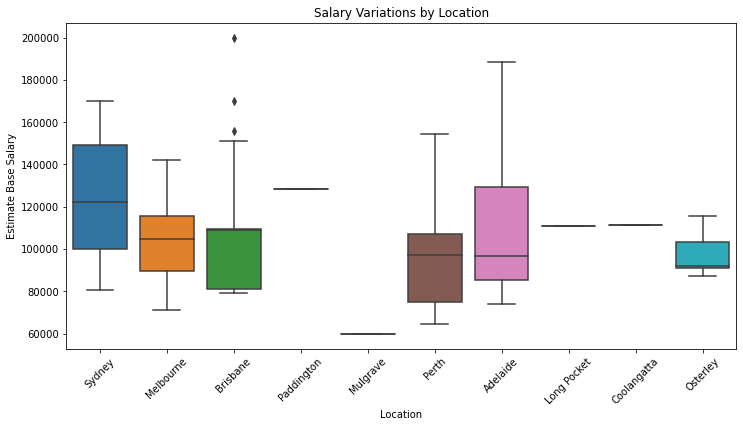

In [584]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Job Location', y='Estimate Base Salary', order=df['Job Location'].value_counts().index[:10])
plt.title('Salary Variations by Location')
plt.xlabel('Location')
plt.ylabel('Estimate Base Salary')
plt.xticks(rotation=45)
plt.show()


- The salary offer in Sydney is the highest, it's followed by Adelaide
- Generally, the salary offered by all cities is around 100 thousand AUD/year

### Question: Are there significant salary variations based on the sector?

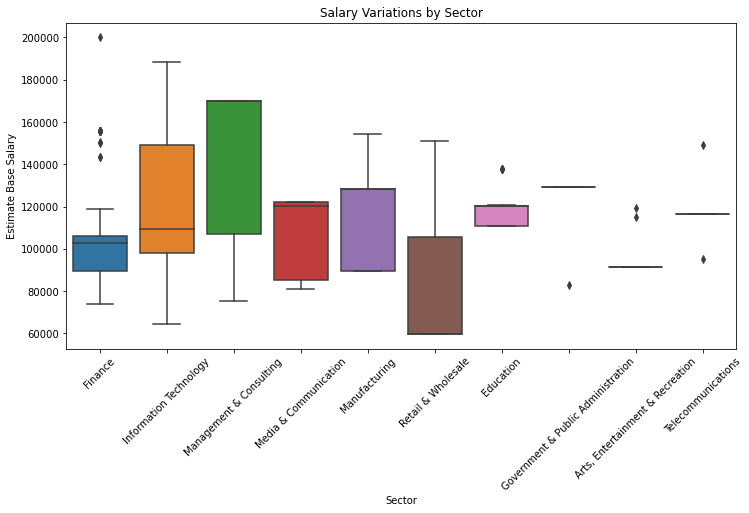

In [585]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Company Sector', y='Estimate Base Salary', order=df['Company Sector'].value_counts().index[:10])
plt.title('Salary Variations by Sector')
plt.xlabel('Sector')
plt.ylabel('Estimate Base Salary')
plt.xticks(rotation=45)
plt.show()


- The finance and retail & wholeshale sectors offer less salary than other sectors
- The Information Technology and Management & Consulting sectors offer the highest salary

## Modeling

### Segment the estimated base salary into groups to identify patterns

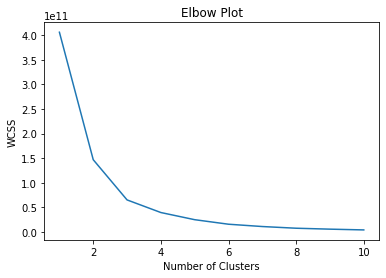

In [586]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df[['Estimate Base Salary']])
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [587]:
# The optimal number of clusters is 3
kmeans = KMeans(n_clusters=3)
kmeans.fit(df[['Estimate Base Salary']])
df['Salary Cluster'] = kmeans.predict(df[['Estimate Base Salary']])

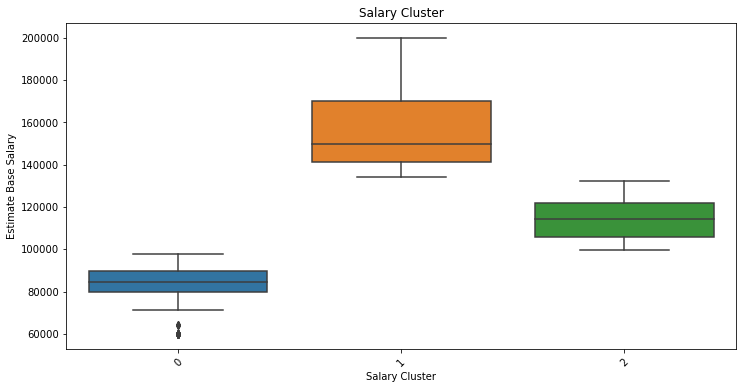

In [588]:
# Explore the clusters
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Salary Cluster', y='Estimate Base Salary')
plt.title('Salary Cluster')
plt.xlabel('Salary Cluster')
plt.ylabel('Estimate Base Salary')
plt.xticks(rotation=45)
plt.show()

- There are 3 main group of salaries
    - The first group is likely to be entry-level roles or roles in finance sector
    - The second group might be mid-level roles and ones that are in high-paying sectors
    - The final group could be senior-level roles

### Create a model to predict the estimate base salary

In [589]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [590]:
# Transform the categorical variables into dummy variables using OrdinalEncoder
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
df['Job Title'] = encoder.fit_transform(df[['Job Title']])
df['Job Location'] = encoder.fit_transform(df[['Job Location']])
df['Company Size'] = encoder.fit_transform(df[['Company Size']])
df['Company Type'] = encoder.fit_transform(df[['Company Type']])
df['Company Sector'] = encoder.fit_transform(df[['Company Sector']])
df['Company Work Life Balance'] = encoder.fit_transform(df[['Company Work Life Balance']])

In [591]:
# Split the data into training and testing sets
X = df[['Job Title', 'Job Location', 'Company Type', 'Company Sector', 'Company Rating']]
y = df['Estimate Base Salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [592]:
# Train the model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2 Score:', r2_score(y_test, y_pred))

Mean Absolute Error: 20599.726786788193
Mean Squared Error: 666347482.9326026
Root Mean Squared Error: 25813.707268282924
R2 Score: 0.10277127792526375


In [593]:
# Use RFE to select the best features
from sklearn.feature_selection import RFE
rfe = RFE(model)
rfe.fit(X_train, y_train)
print(rfe.support_)
print(rfe.ranking_)
print(X_train.columns)

[ True False False False  True]
[1 3 2 4 1]
Index(['Job Title', 'Job Location', 'Company Type', 'Company Sector',
       'Company Rating'],
      dtype='object')


In [594]:
# Build a model using the selected features
X_rfe =  X_train[X_train.columns[rfe.support_]]
X_test_rfe = X_test[X_test.columns[rfe.support_]]
model.fit(X_rfe, y_train)
y_pred = model.predict(X_test_rfe)
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2 Score:', r2_score(y_test, y_pred))

Mean Absolute Error: 20674.71870949232
Mean Squared Error: 697576395.4910786
Root Mean Squared Error: 26411.671576995624
R2 Score: 0.0607219297633842


The model didn't improve much by using the selected features so we're going to try Polymonial Regression

In [595]:
# Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures
# Find the optimal degree using RFE mode
degrees = [1, 2, 3, 4, 5]
for degree in degrees:
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X_train)
    X_test_poly = poly.fit_transform(X_test)
    model.fit(X_poly, y_train)
    y_pred = model.predict(X_test_poly)
    print('Degree:', degree)
    print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
    print('R2 Score:', r2_score(y_test, y_pred))

Degree: 1
Mean Absolute Error: 20599.726786788186
Mean Squared Error: 666347482.9326026
Root Mean Squared Error: 25813.707268282924
R2 Score: 0.10277127792526375
Degree: 2
Mean Absolute Error: 14163.194527474454
Mean Squared Error: 390600552.40388304
Root Mean Squared Error: 19763.616885678668
R2 Score: 0.47406114159439405
Degree: 3
Mean Absolute Error: 32721.743362831858
Mean Squared Error: 3006654478.216814
Root Mean Squared Error: 54832.968898435676
R2 Score: -3.0484234191721384
Degree: 4
Mean Absolute Error: 305944.56111293554
Mean Squared Error: 1805735282930.3972
Root Mean Squared Error: 1343776.5003639546
R2 Score: -2430.400435668446
Degree: 5
Mean Absolute Error: 116839.3307180489
Mean Squared Error: 258610573936.86328
Root Mean Squared Error: 508537.6819242241
R2 Score: -347.21596946266965


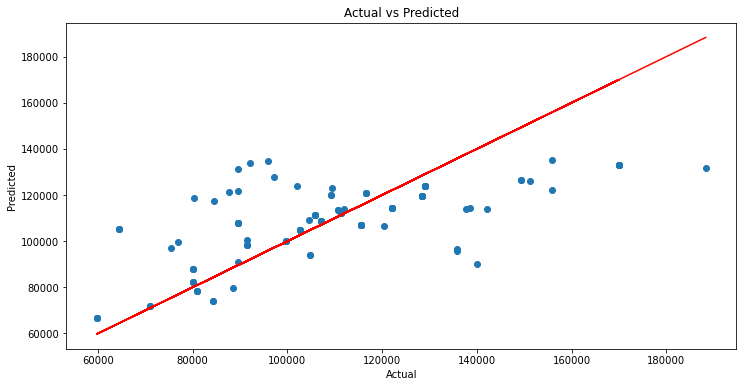

In [596]:
# Plot the actual vs predicted values with a 45 degree line to see how well the model is performing when degree = 2
poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)
model.fit(X_poly, y_train)
y_pred = model.predict(X_test_poly)
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred)
plt.plot(y_test, y_test, color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

- The Polynomial Regression with a degree of 2 has the lowest MAE and highest R^2 score so we're going to use that model
- The model was able to explain 47% of the variation in the salary data but its performance is still insufficient based on the purpose of using it to predict the salary
- The model could be improved by implementing more advanced models like Neural Networks, parameter tuning, and feature engineering

## Key takeaways

- Sydney and Melbourne have the most job listings and the numbers are substantially more than all other cities combined
- The capital city, which is Canberra, doesn't have many job listings since it wasn't in the top 10
- The finance sector demands the most data roles, it's tripled the number of roles offered by the second-highest sector but it offers lower salary compared to the other sectors
- Companies with 1000 to 5000 employees generally offer more than 100 to 180 thousand AUD a year
- The salary offer in Sydney is the highest, it's followed by Adelaide
- The Information Technology Management & Consulting sectors offer the highest salary
- There are 3 main group of salaries from 60-100k/year, 100-135k/year, and 135-200k/year (AUD)